# Spline

In [18]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from patsy import dmatrix
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

In [19]:
filepath = '../../../../../data/processed/df_filtered.xlsx'
df = pd.read_excel(filepath)
df

island_ids  years region_codes  prefecture_codes  populations  \
0            68   1975        33342                33           46   
1            68   1980        33342                33           52   
2            68   1985        33342                33           53   
3            68   1990        33342                33           54   
4            68   1995        33342                33           45   
..          ...    ...          ...               ...          ...   
622         218   2000        38203                38          451   
623         218   2005        38203                38          473   
624         218   2010        38203                38          414   
625         218   2015        38203                38          344   
626         218   2020        38203                38          263   

     treatment_group  treatment_group_mainland  year_bridges_opened  \
0                  1                         1                 2015   
1                  1                         1                 2015   
2                  1                         1                 2015   
3                  1                         1                 2015   
4                  1                         1                 2015   
..               ...                       ...                  ...   
622                0                         0                    0   
623                0                         0                    0   
624                0                         0                    0   
625                0                         0                    0   
626                0                         0                    0   

     after_treated  year_connect_mainland  after_treated_mainland  \
0                0                   2015                       0   
1                0                   2015                       0   
2                0                   2015                       0   
3                0                   2015                       0   
4                0                   2015                       0   
..             ...                    ...                     ...   
622              0                      0                       0   
623              0                      0                       0   
624              0                      0                       0   
625              0                      0                       0   
626              0                      0                       0   

           income  area_km2  distance_m  population_change_rate  \
0             NaN     10.14      728.12              -22.033898   
1             NaN     10.14      728.12               13.043478   
2    8.200295e+06     10.14      728.12                1.923077   
3    9.799848e+06     10.14      728.12                1.886792   
4    1.244189e+03     10.14      728.12              -16.666667   
..            ...       ...         ...                     ...   
622  6.966687e+03      2.76     1090.00              -11.394892   
623  6.264367e+03      2.76     1090.00                4.878049   
624  7.925102e+03      2.76     1090.00              -12.473573   
625  7.234493e+03      2.76     1090.00              -16.908213   
626  7.644017e+03      2.76     1090.00              -23.546512   

     control_group  time_since_intervention  
0                0                      -40  
1                0                      -35  
2                0                      -30  
3                0                      -25  
4                0                      -20  
..             ...                      ...  
622              1                        0  
623              1                        0  
624              1                        0  
625              1                        0  
626              1                        0  

[627 rows x 17 columns]

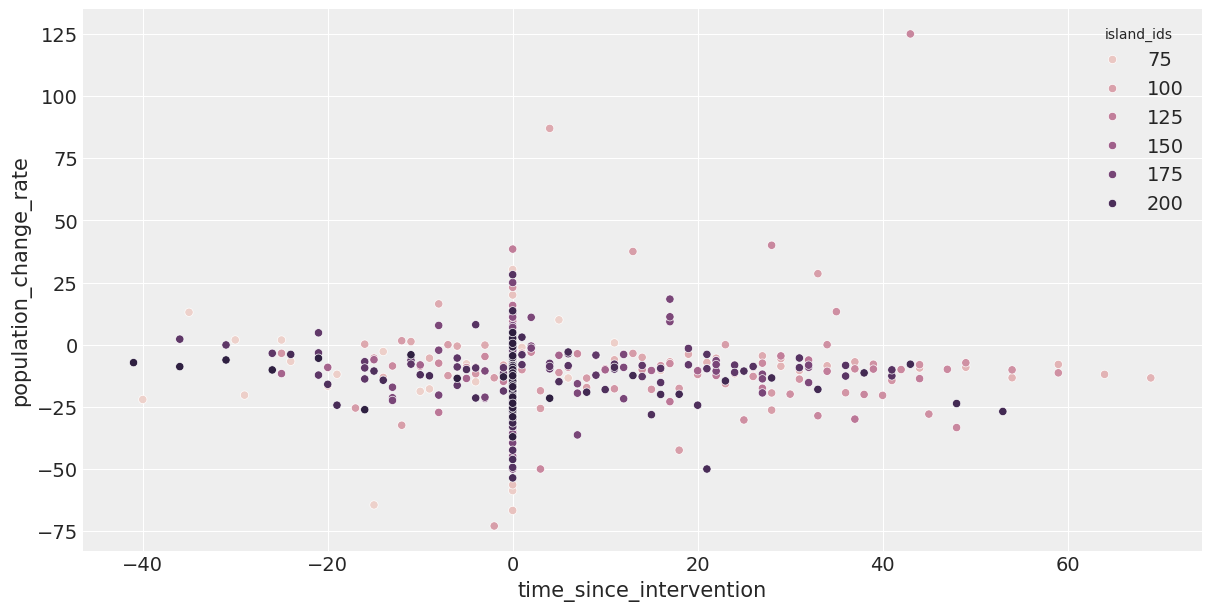

In [56]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='time_since_intervention', y='population_change_rate', data=df, hue='island_ids');

In [178]:
num_knots = 6
knot_list = np.quantile(df.time_since_intervention, np.linspace(0, 1, num_knots))
knot_list

array([-41.,   0.,   0.,   0.,  11.,  69.])

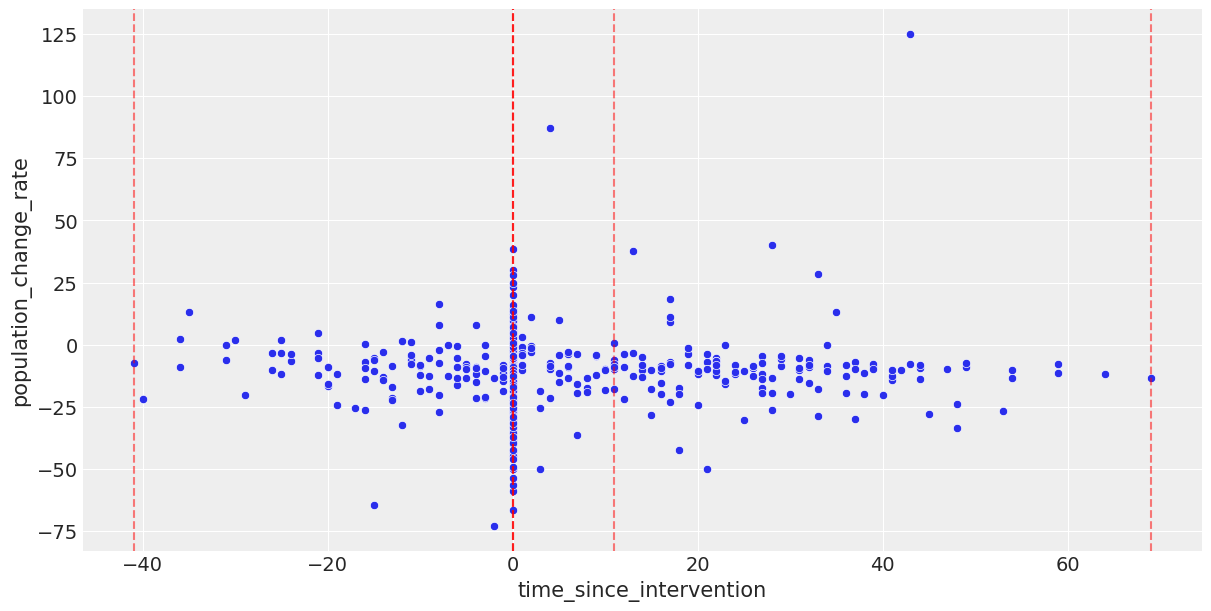

In [179]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='time_since_intervention', y='population_change_rate', data=df)
for knot in knot_list:
    plt.gca().axvline(knot, color='red', linestyle='--', alpha=0.5)

In [180]:
# スプラインの準備
B = dmatrix(
    "bs(time_since_intervention, knots=knot_list[1:-1], degree=3, include_intercept=True) - 1",
    {"time_since_intervention": df.time_since_intervention.values, "knot_list": knot_list},
)

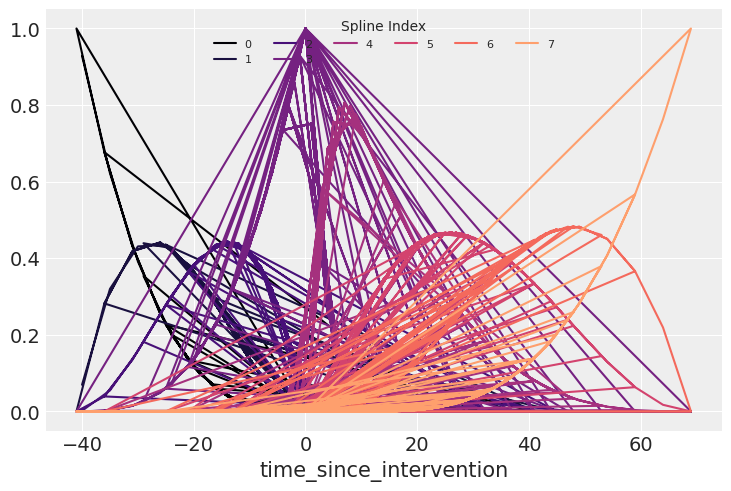

In [181]:
spline_df = (
    pd.DataFrame(B)
    .assign(time_since_intervention=df.time_since_intervention.values)
    .melt("time_since_intervention", var_name="spline_i", value_name="value")
)

color = plt.cm.magma(np.linspace(0, 0.80, len(spline_df.spline_i.unique())))

fig = plt.figure()
for i, c in enumerate(color):
    subset = spline_df.query(f"spline_i == {i}")
    subset.plot("time_since_intervention", "value", c=c, ax=plt.gca(), label=i)
plt.legend(title="Spline Index", loc="upper center", fontsize=8, ncol=6);

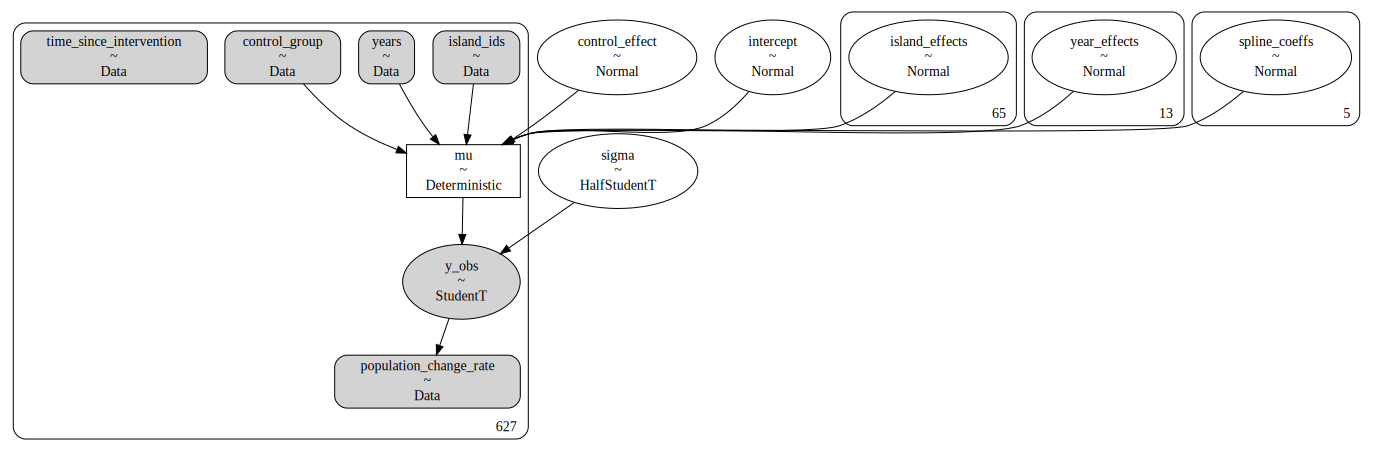

In [170]:
# 0から始まるインデックスを振り直す
df['island_ids'], unique_island_ids = pd.factorize(df['island_ids'])
df['years'], unique_years = pd.factorize(df['years'])

# 次元の定義
COORDS = {
    'control_group': df['control_group'].unique(),
    'island_ids': unique_island_ids,
    'year_ids': unique_years,
    'time_since_intervention_ids': df['time_since_intervention'].unique(),
    'obs_id': df.index
}

with pm.Model(coords=COORDS) as model:
    # data
    time_shared = pm.Data('time_since_intervention', df['time_since_intervention'])
    population_change_rate_shared = pm.Data('population_change_rate', df['population_change_rate'])
    island_ids_shared = pm.Data('island_ids', df['island_ids'])
    years_shared = pm.Data('years', df['years'])
    control_group_shared = pm.Data('control_group', df['control_group'])

    # prior
    intercept = pm.Normal('intercept', mu=0, sigma=100)
    control_effect = pm.Normal('control_effect', mu=0, sigma=100)
    island_effects = pm.Normal('island_effects', mu=0, sigma=100, shape=len(df['island_ids'].unique()))
    year_effects = pm.Normal('year_effects', mu=0, sigma=100, shape=len(df['years'].unique()))

    # spline coefficients
    spline_coeffs = pm.Normal('spline_coeffs', mu=0, sigma=100, shape=B.shape[1])

    # spline effects
    spline_effects = pm.math.dot(B, spline_coeffs.T)

    # link function
    mu = pm.Deterministic('mu', intercept + control_effect * control_group_shared + island_effects[island_ids_shared] + year_effects[years_shared] + spline_effects)

    # likelihood
    sigma = pm.HalfStudentT('sigma', nu=3, sigma=100)
    y_obs = pm.StudentT('y_obs', nu=3, mu=mu, sigma=sigma, observed=population_change_rate_shared)

pm.model_to_graphviz(model)

In [171]:
with model:
    idata = pm.sample(
        draws=1000,
        tune=1000,
        nuts_sampler='numpyro',
        cores=4,
        random_seed=123,
    )

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


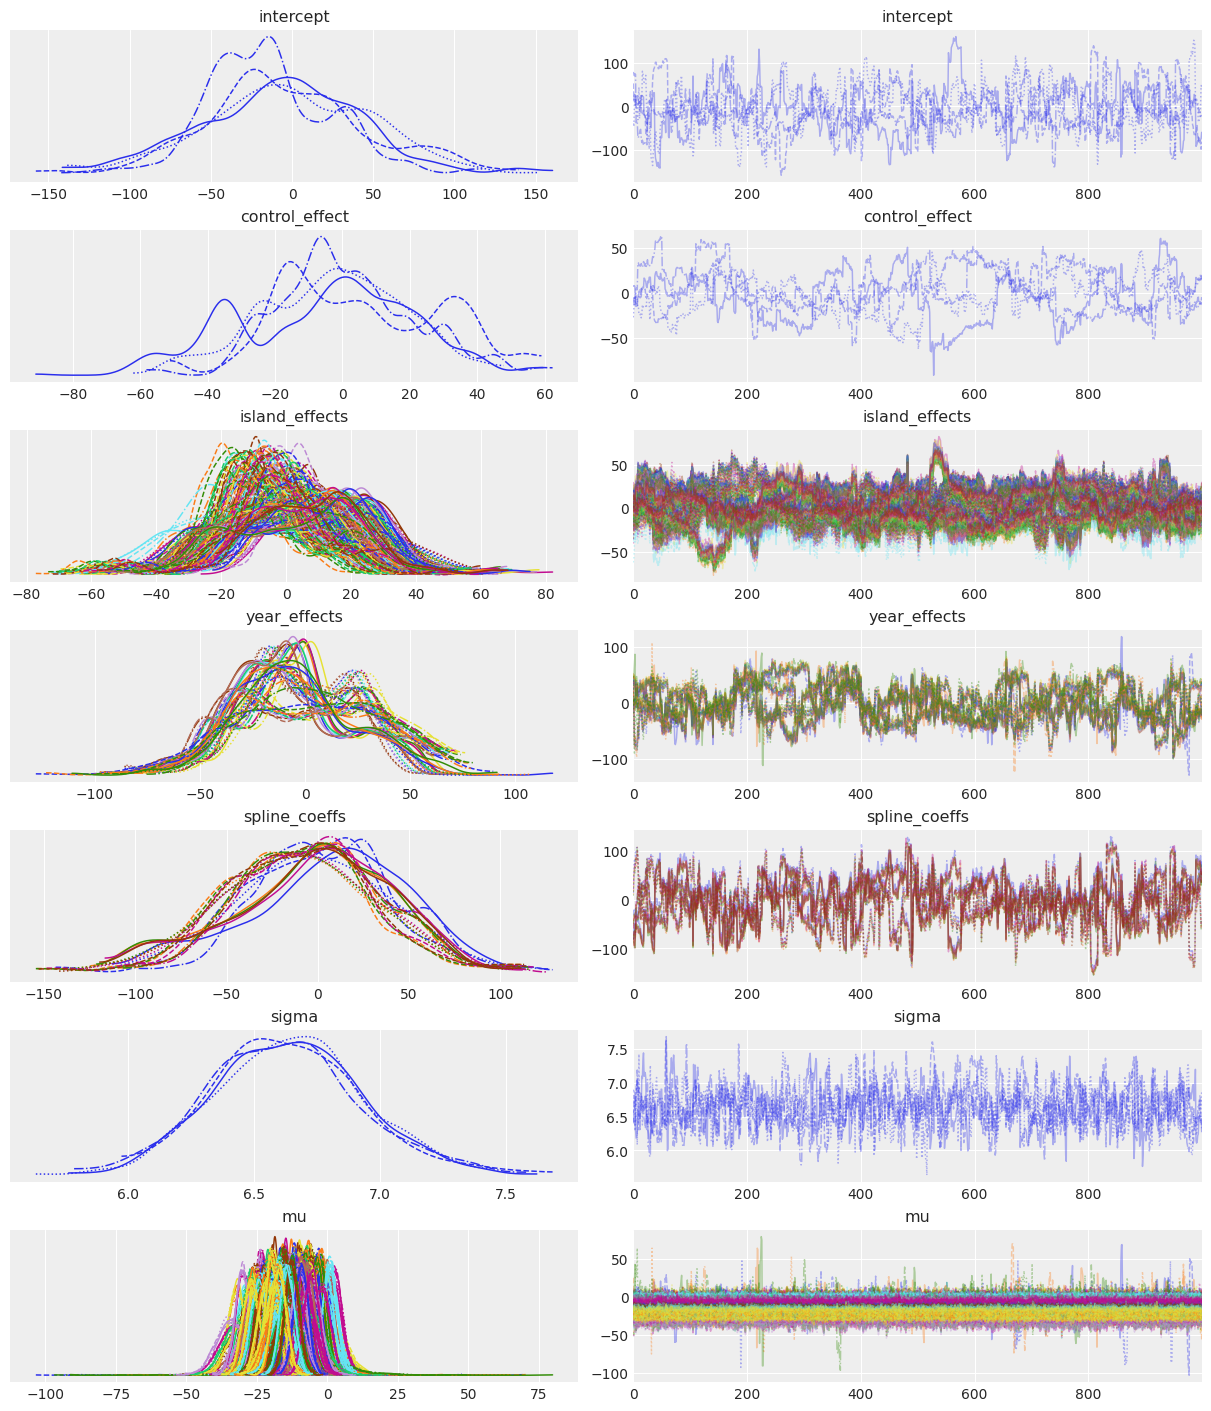

In [172]:
az.plot_trace(idata);

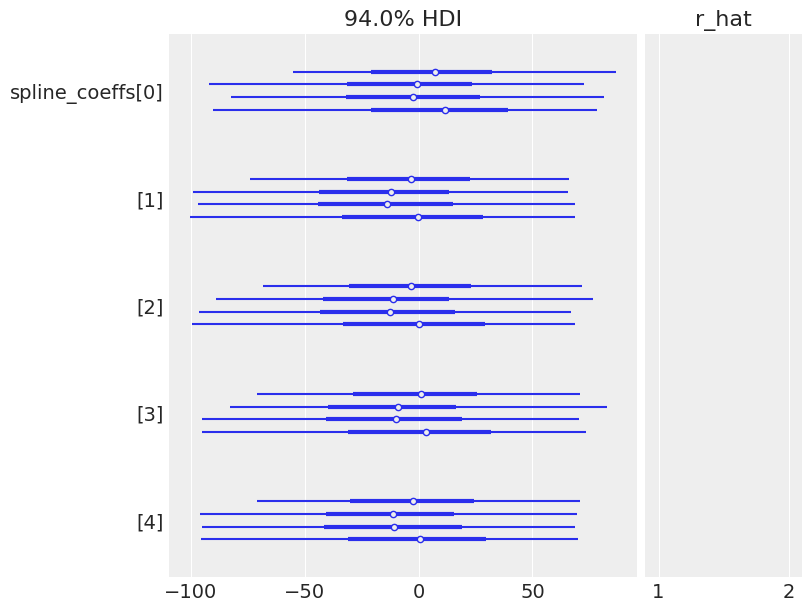

In [173]:
az.plot_forest(idata, var_names=["spline_coeffs"], combined=False, r_hat=True);

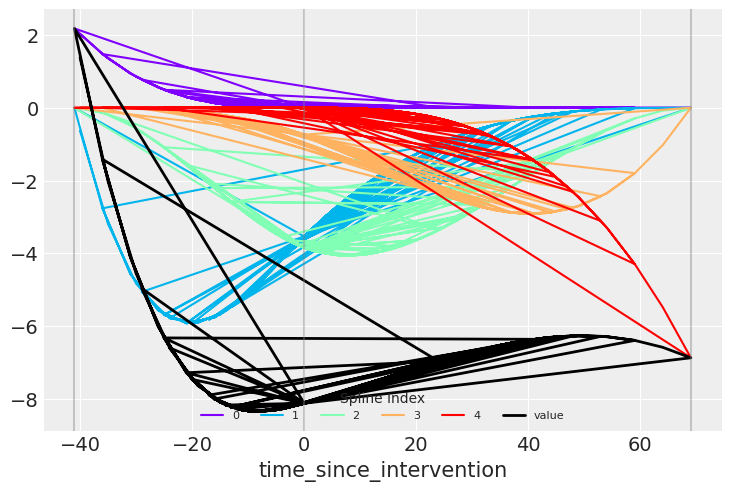

In [174]:
spline_coeffs_p = idata.posterior["spline_coeffs"].mean(("chain", "draw")).values

spline_df = (
    pd.DataFrame(B * spline_coeffs_p.T)
    .assign(time_since_intervention=df.time_since_intervention.values)
    .melt("time_since_intervention", var_name="spline_i", value_name="value")
)

spline_df_merged = (
    pd.DataFrame(np.dot(B, spline_coeffs_p.T))
    .assign(time_since_intervention=df.time_since_intervention.values)
    .melt("time_since_intervention", var_name="spline_i", value_name="value")
)


color = plt.cm.rainbow(np.linspace(0, 1, len(spline_df.spline_i.unique())))
fig = plt.figure()
for i, c in enumerate(color):
    subset = spline_df.query(f"spline_i == {i}")
    subset.plot("time_since_intervention", "value", c=c, ax=plt.gca(), label=i)
spline_df_merged.plot("time_since_intervention", "value", c="black", lw=2, ax=plt.gca())
plt.legend(title="Spline Index", loc="lower center", fontsize=8, ncol=6)

for knot in knot_list:
    plt.gca().axvline(knot, color="grey", alpha=0.4);

In [175]:
post_pred = az.summary(idata, var_names=["mu"]).reset_index(drop=True)
df_post = df.copy().reset_index(drop=True)
df_post["pred_mean"] = post_pred["mean"]
df_post["pred_hdi_lower"] = post_pred["hdi_3%"]
df_post["pred_hdi_upper"] = post_pred["hdi_97%"]

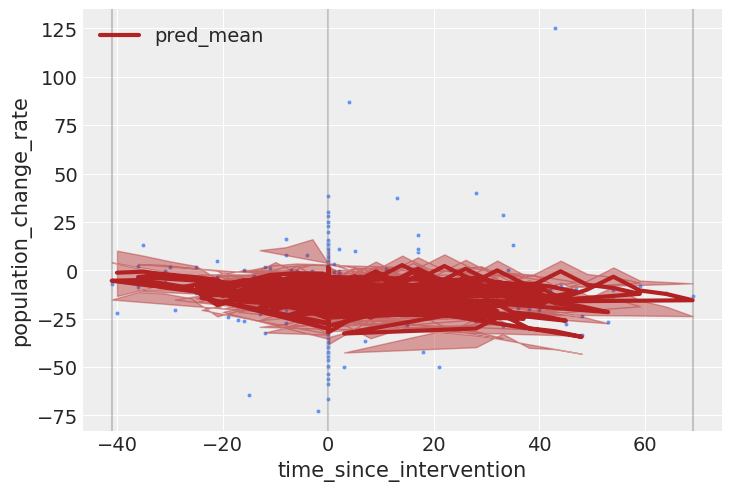

In [177]:
sns.scatterplot(
    x="time_since_intervention",
    y="population_change_rate",
    data=df,
    color="cornflowerblue",
    s=10,
)
for knot in knot_list:
    plt.gca().axvline(knot, color="grey", alpha=0.4)

df_post.plot("time_since_intervention", "pred_mean", ax=plt.gca(), lw=3, color="firebrick")
plt.fill_between(
    df_post.time_since_intervention,
    df_post.pred_hdi_lower,
    df_post.pred_hdi_upper,
    color="firebrick",
    alpha=0.4,
);

## TWFE

$$
\mu_{it} = \text{control}_i + \text{island}_i + \text{year}_t + \sum_{g \in G} \mu_g \mathbf{1} \{\text{year}_t-\text{intervention}_t \in g\} + \epsilon_{it}
$$

- $\text{control}_i$:
  - コントロール郡ダミー
- $\text{island}_i$:
  - 個体効果
- $\text{intervention}_t$:
  - 介入年
- $g$:
  - 介入年からの経過年数

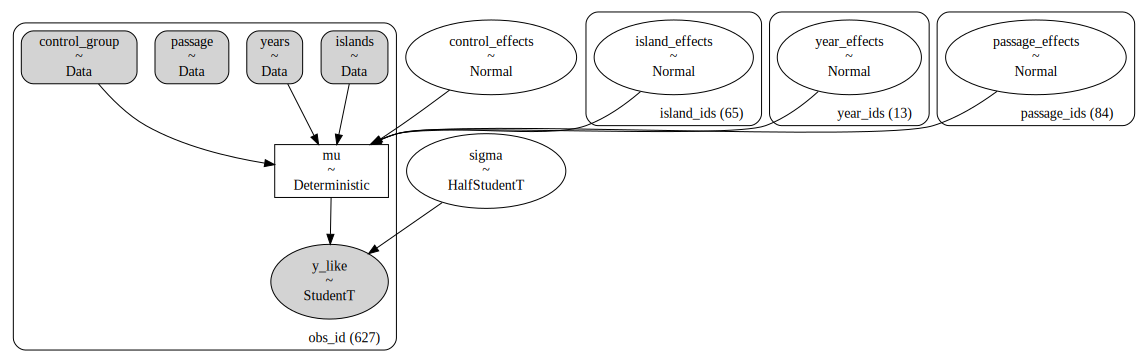

In [5]:
# 経過期間ダミーを作成
passages = dmatrix('C(passage_of_year)', data=df, return_type='dataframe')

# 0から始まるインデックスを振り直す
df['island_ids'], unique_island_ids = pd.factorize(df['island_ids'])
df['years'], unique_years = pd.factorize(df['years'])

# 次元の定義
coords = {
    'control_group': df['control_group'].unique(),
    'island_ids': unique_island_ids,
    'year_ids': unique_years,
    'passage_ids': df['passage_of_year'].unique(),
    'obs_id': df.index
}

with pm.Model(coords=coords) as twfe:
    # data
    control_group = pm.Data('control_group', df['control_group'], dims='obs_id')
    islands = pm.Data('islands', df['island_ids'], dims='obs_id')
    years = pm.Data('years', df['years'], dims='obs_id')
    passage = pm.Data('passage', df['passage_of_year'], dims='obs_id')

    # priors
    control_effects = pm.Normal('control_effects', mu=0, sigma=100)
    island_effects = pm.Normal('island_effects', mu=0, sigma=100, dims='island_ids')
    year_effects = pm.Normal('year_effects', mu=0, sigma=100, dims='year_ids')
    passage_effects = pm.Normal('passage_effects', mu=0, sigma=100, dims='passage_ids')

    # model error
    sigma = pm.HalfStudentT('sigma', nu=4, sigma=100)

    # expectation
    mu = pm.Deterministic('mu', control_effects * control_group + island_effects[islands] + year_effects[years] + pm.math.dot(passages, passage_effects), dims='obs_id')

    # likelihood
    y_like = pm.StudentT('y_like', nu=4, mu=mu, sigma=sigma, observed=df['population_change_rate'].values, dims='obs_id')

pm.model_to_graphviz(twfe)

In [ ]:
with twfe:
    idata_twfe = pm.sample(draws=3000, tune=2000, nuts_sampler='numpyro', cores=4, random_seed=42)

# 保存
az.to_netcdf(idata_twfe, './sample/sample_baysian_did_twfe.nc')

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [8]:
az.summary(idata_twfe, hdi_prob=.95, var_names=['control_effects'])

mean      sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
control_effects -3.946  29.923   -63.366     54.593      0.748    0.529   

                 ess_bulk  ess_tail  r_hat  
control_effects    1599.0    2968.0    1.0

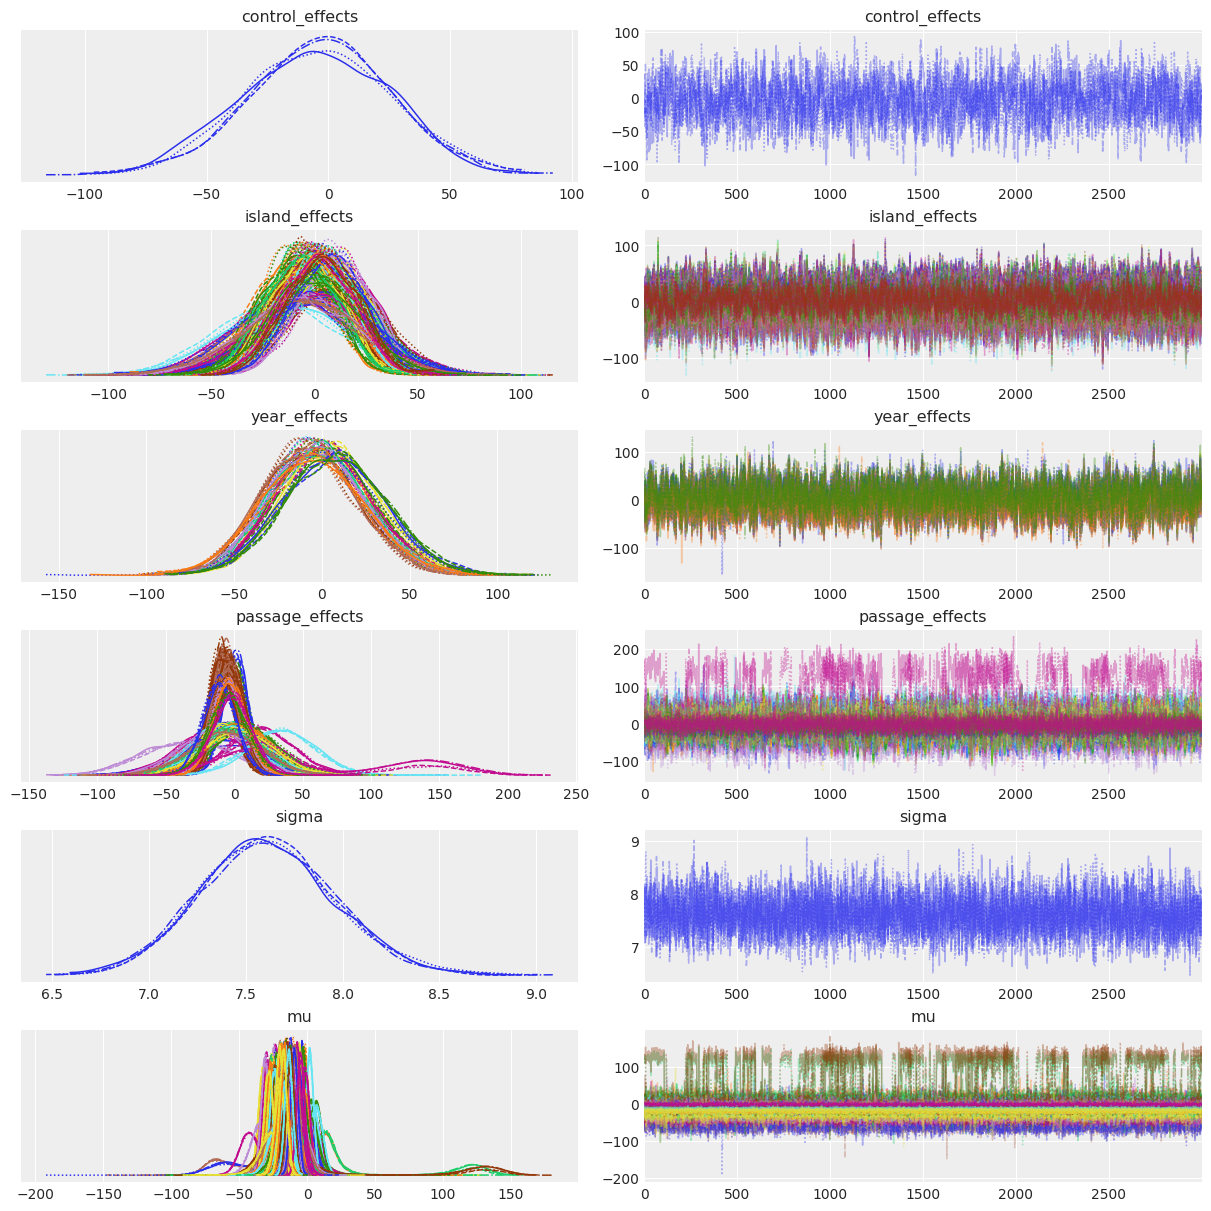

In [9]:
az.plot_trace(idata_twfe);

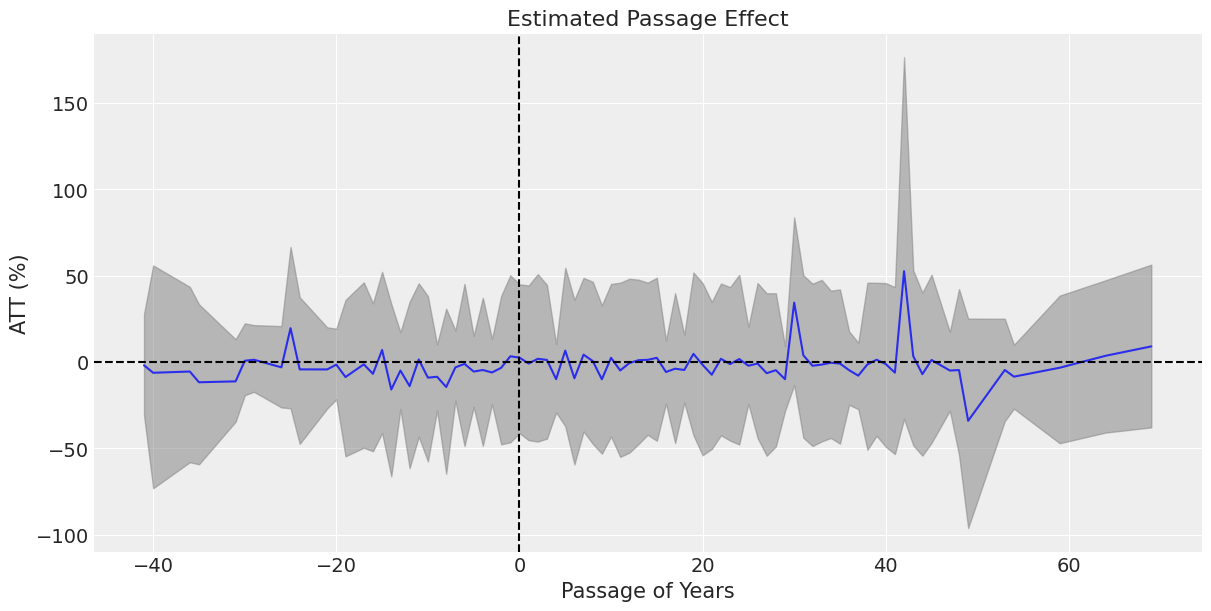

In [14]:
summary = az.summary(idata_twfe, var_names=['passage_effects'], hdi_prob=.95)
df_passage_effects = summary.reset_index()
# 数値部分を取り出す関数
def extract_number(index_str):
    match = re.search(r'\[(.*?)\]', index_str)
    return int(match.group(1)) if match else None

# 数値部分を新しい列として追加
df_passage_effects['passage_years'] = df_passage_effects['index'].apply(extract_number)
df_passage_effects.sort_values('passage_years', inplace=True)

plt.figure(figsize=(12, 6))
sns.lineplot(x='passage_years', y='mean', data=df_passage_effects)
plt.fill_between(
    df_passage_effects['passage_years'],
    df_passage_effects['hdi_2.5%'],
    df_passage_effects['hdi_97.5%'],
    color='gray',
    alpha=0.5,
    label='95% HDI'
)
plt.axhline(y=0, color='black', linestyle='--', label='ATT = 0')
plt.axvline(x=0, color='black', linestyle='--', label='treatment')
plt.title('Estimated Passage Effect')
plt.xlabel('Passage of Years')
plt.ylabel('ATT (%)')
plt.show()

## Staggered DiD

$$
\mu_{it} = \text{control}_i + \text{island}_i + \text{year}_t + \sum_{g \in G} \mu_{gl} \mathbf{1} \{\text{year}-\text{intervention}_i \in g\} \cdot \mathbf{1} \{\text{intervention}_i \in e\} + \epsilon_{it}
$$

- $\text{control}_i$:
  - コントロール郡ダミー
- $\text{island}_i$:
  - 島効果
- $\text{year}_t$:
  - 年効果
- $\mathbf{1} \{\text{year}-\text{intervention}_i \in g\}$:
  - 経過年数ダミー
- $\mathbf{1} \{\text{intervention}_t \in e\}$
  - 処置開始年ダミー


### モデル1

In [29]:
cohort_list = df['year_bridges_opened'].unique()
cohort_list = cohort_list[cohort_list != 0]
cohort_list.sort()
for cohort in cohort_list:
    globals()[f'c{cohort}'] = dmatrix(f'C(years_cohort_{cohort})-1', data=df, return_type='dataframe')
    print(cohort)

1951
1961
1967
1972
1973
1975
1976
1979
1983
1987
1988
1989
1991
1992
1995
1996
1999
2000
2004
2011
2015
2016


In [40]:
def get_cohort_dims(cohort_list):
    {f'n_c{cohort}': globals()[f'c{cohort}'] for cohort in cohort_list}

def get_cohort_priors(cohort_list):
    priors = {}
    for cohort in cohort_list:
        priors[f'mu_c{cohort}'] = pm.Normal(f'mu_c{cohort}', mu=0, sigma=100, dims=f'n_c{cohort}')
    return priors

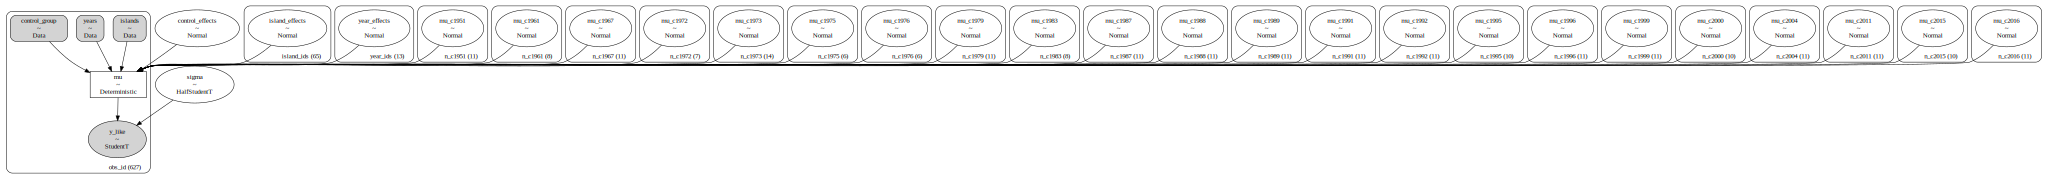

In [41]:
# 0から始まるインデックスを振り直す
df['island_ids'], unique_island_ids = pd.factorize(df['island_ids'])
df['years'], unique_years = pd.factorize(df['years'])

# 次元の定義
coords = {
    'control_group': df['control_group'].unique(),
    'island_ids': unique_island_ids,
    'year_ids': unique_years,
    'obs_id': df.index
}
coords.update({f'n_c{cohort}': globals()[f'c{cohort}'] for cohort in cohort_list})


with pm.Model(coords=coords) as staggered:
    # data
    control_group = pm.Data('control_group', df['control_group'], dims='obs_id')
    islands = pm.Data('islands', df['island_ids'], dims='obs_id')
    years = pm.Data('years', df['years'], dims='obs_id')

    # priors
    control_effects = pm.Normal('control_effects', mu=0, sigma=100)
    island_effects = pm.Normal('island_effects', mu=0, sigma=100, dims='island_ids')
    year_effects = pm.Normal('year_effects', mu=0, sigma=100, dims='year_ids')

    # model error
    sigma = pm.HalfStudentT('sigma', nu=4, sigma=100)

    # cohort * passage
    cohort_priors = get_cohort_priors(cohort_list)

    # cohort effects
    cohort_effects = sum(pm.math.dot(globals()[f'c{cohort}'], cohort_priors[f'mu_c{cohort}']) for cohort in cohort_list)

    # expectation
    mu = pm.Deterministic('mu', control_effects * control_group + island_effects[islands] + year_effects[years] + cohort_effects, dims='obs_id')

    # likelihood
    y_like = pm.StudentT('y_like', nu=4, mu=mu, sigma=sigma, observed=df['population_change_rate'].values, dims='obs_id')

pm.model_to_graphviz(staggered)

- $\hat{R} > 1$ の記録
  - draws: 4000, tune: 2000
  - draws: 4000, tune: 3000
  - draws: 5000, tune: 3000

In [42]:
with staggered:
    idata_staggered = pm.sample(
        draws=5000,
        tune=5000,
        nuts_sampler="numpyro",
        cores=2,
        random_seed=42
    )
az.to_netcdf(idata_staggered, './sample/sample_baysian_did_staggered.nc')

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


'./sample/sample_baysian_did_staggered.nc'

In [43]:
az.summary(idata_staggered, hdi_prob=0.95, var_names=['control_effects'])

mean      sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
control_effects -3.53  26.521    -54.65      49.32       2.14    1.516   

                 ess_bulk  ess_tail  r_hat  
control_effects     153.0     340.0   1.01

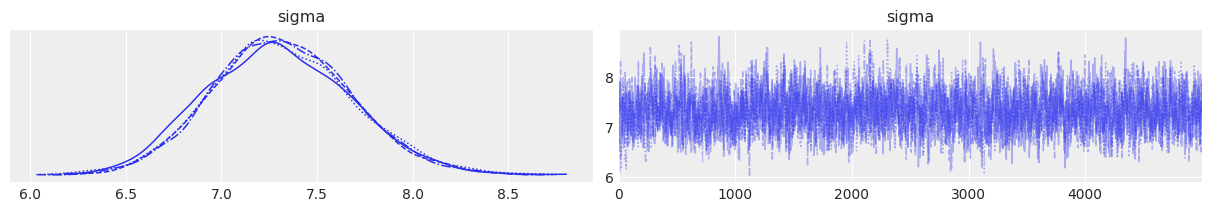

In [44]:
az.plot_trace(idata_staggered, var_names=['sigma']);

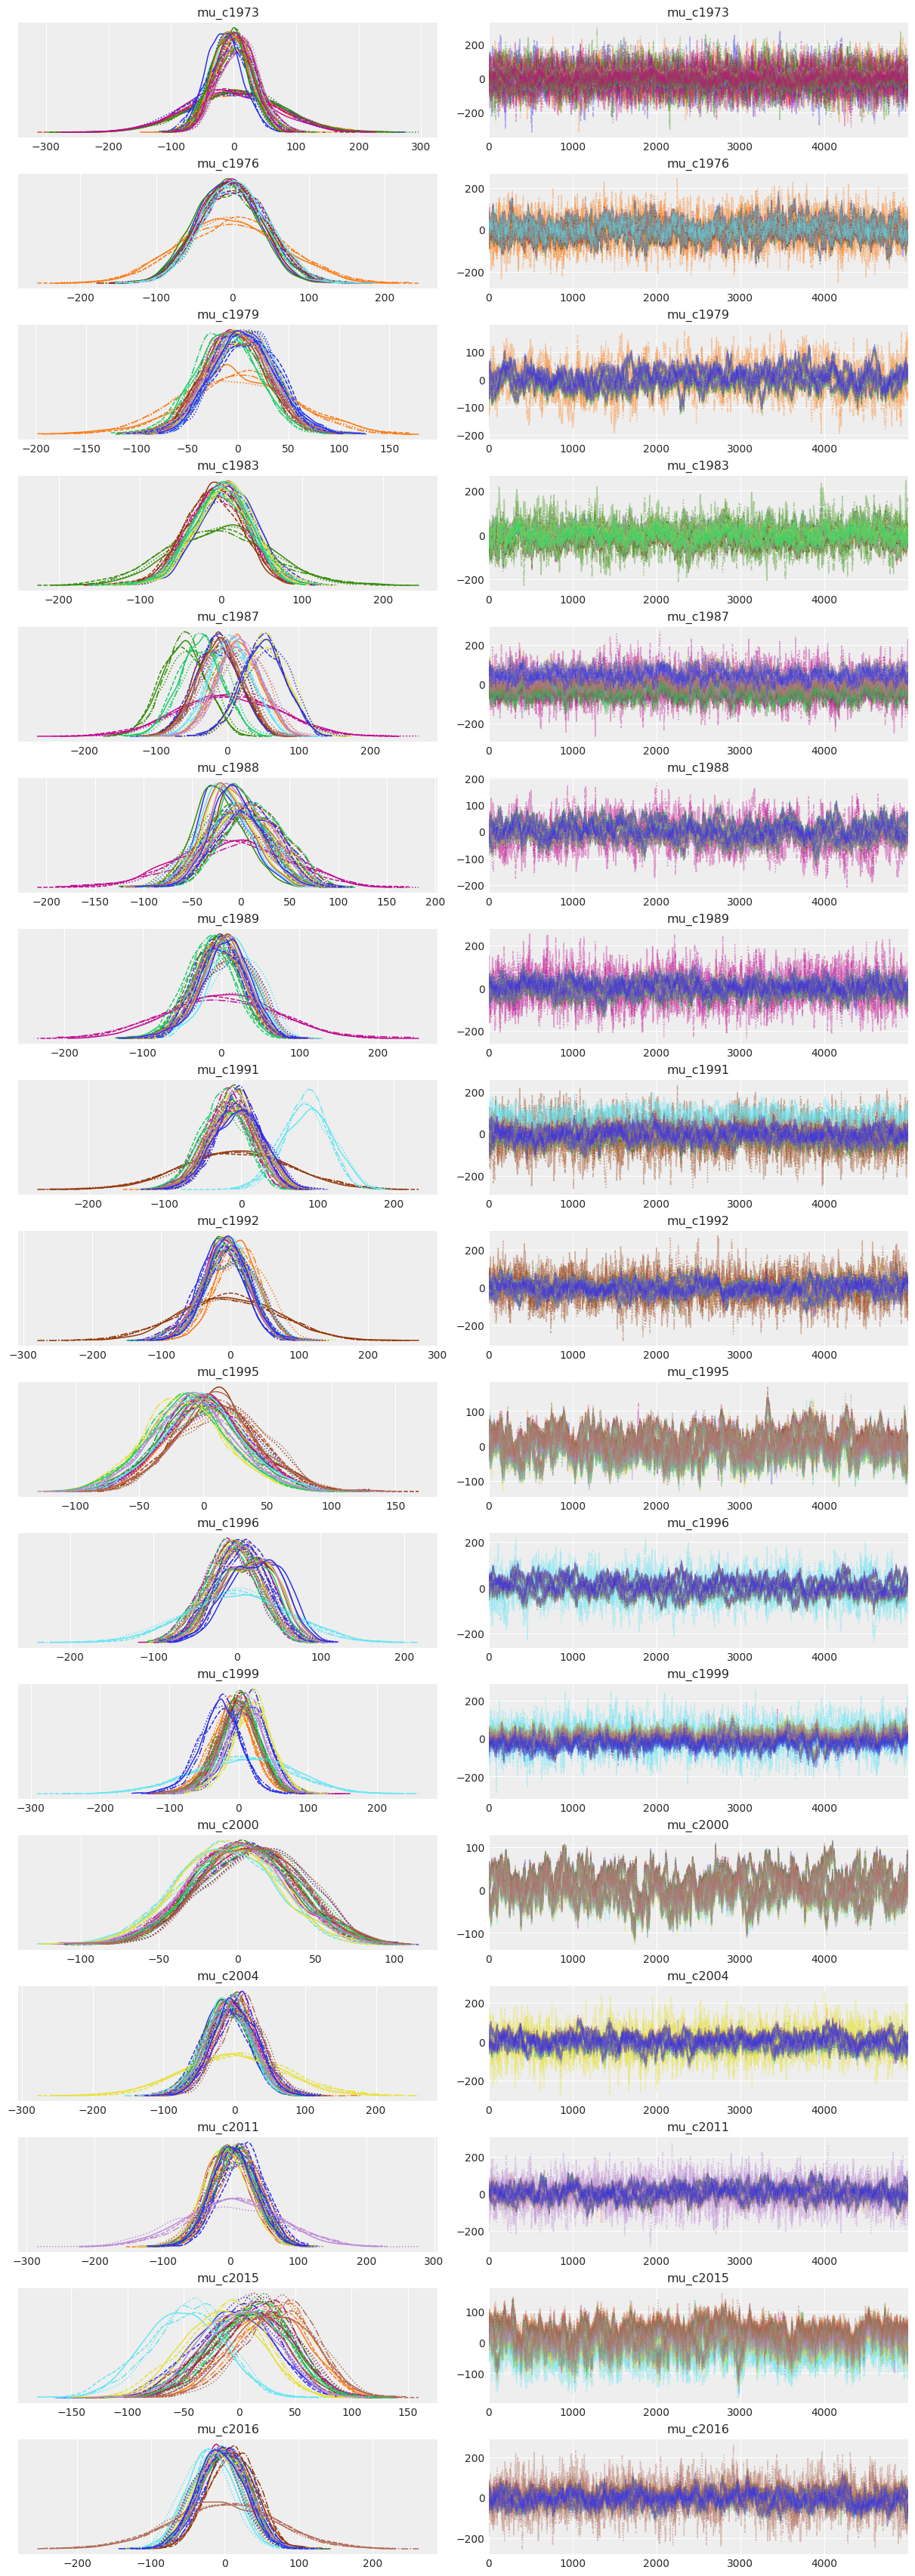

In [45]:
az.plot_trace(idata_staggered, var_names=['mu_c1973', 'mu_c1976', 'mu_c1979', 'mu_c1983', 'mu_c1987', 'mu_c1988', 'mu_c1989', 'mu_c1991', 'mu_c1992', 'mu_c1995', 'mu_c1996', 'mu_c1999', 'mu_c2000', 'mu_c2004', 'mu_c2011', 'mu_c2015', 'mu_c2016']);

In [48]:
def get_passage_effects(cohort):
    summary = az.summary(idata_staggered, var_names=[f'mu_c{cohort}'], hdi_prob=.95)
    df_cohort_effects_ = summary.reset_index()
    # 数値部分を取り出す関数
    def extract_number(index_str):
        match = re.search(r'\[(-?\d+)\]', index_str)
        return int(match.group(1)) if match else None

    # 数値部分を新しい列として追加
    df_cohort_effects_['passage_years'] = df_cohort_effects_['index'].apply(extract_number)
    df_cohort_effects_.sort_values('passage_years', inplace=True)

    plt.figure(figsize=(12, 6))
    sns.lineplot(x='passage_years', y='mean', data=df_cohort_effects_, label='mean')
    plt.fill_between(
        df_cohort_effects_['passage_years'],
        df_cohort_effects_['hdi_2.5%'],
        df_cohort_effects_['hdi_97.5%'],
        color='gray', alpha=0.3, label='95% HDI'
    )
    sns.scatterplot(x='passage_years', y='mean', data=df_cohort_effects_, color='red', s=50, label='observed')
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
    plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
    plt.title(f'Estimated Passage Effect of {cohort}')
    plt.xlabel('Passage of Years')
    plt.ylabel('ATT (%)')
    plt.show()

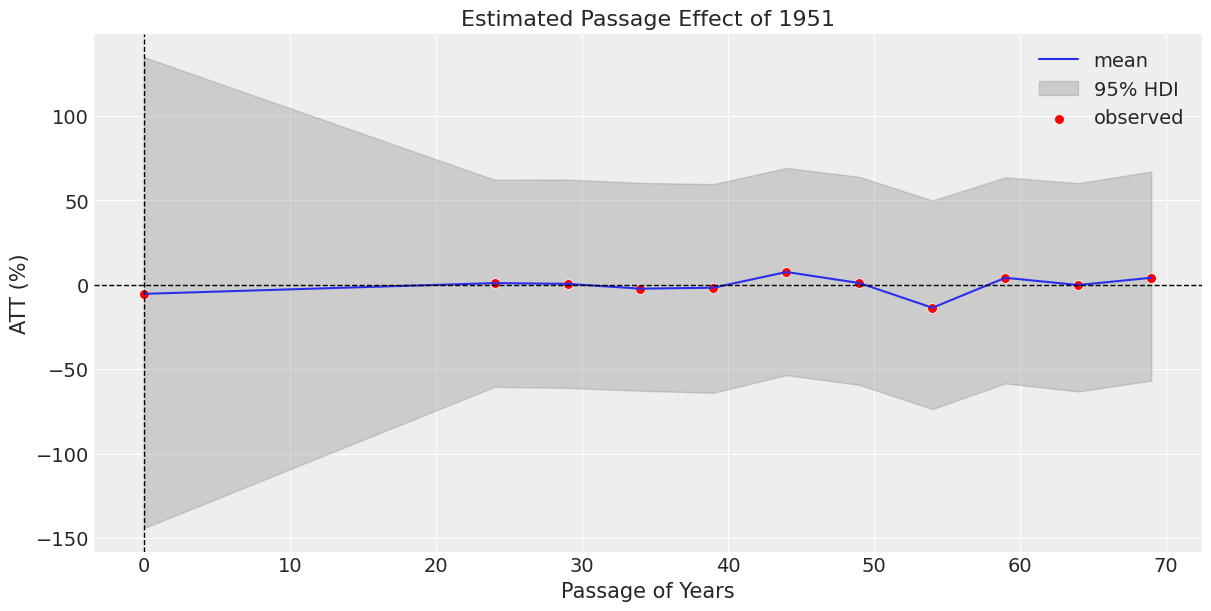

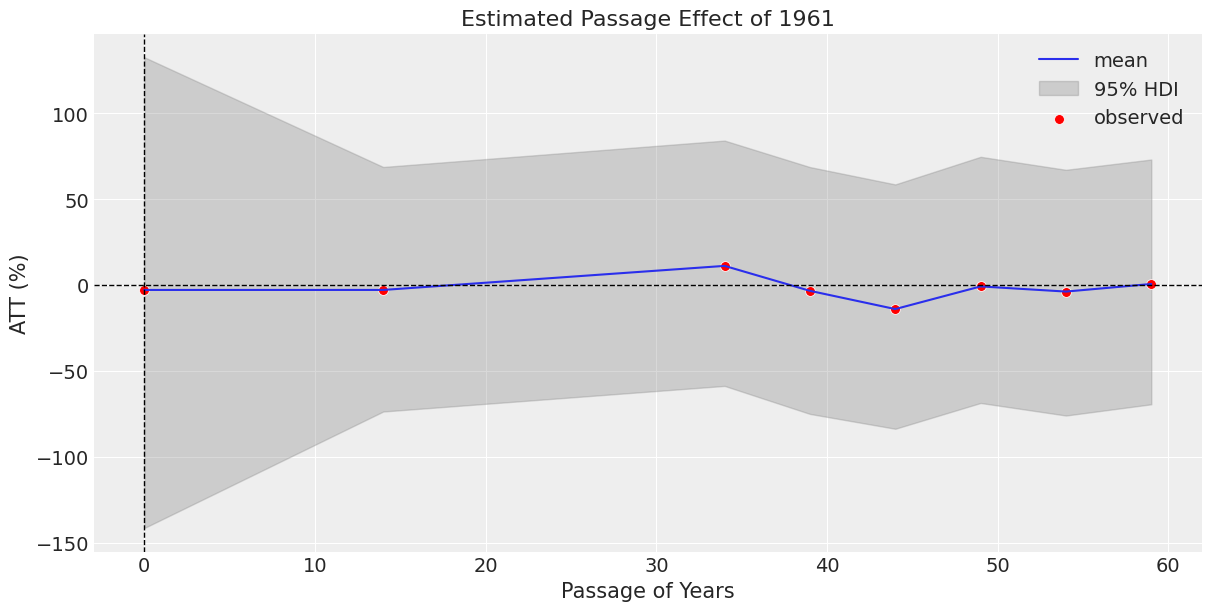

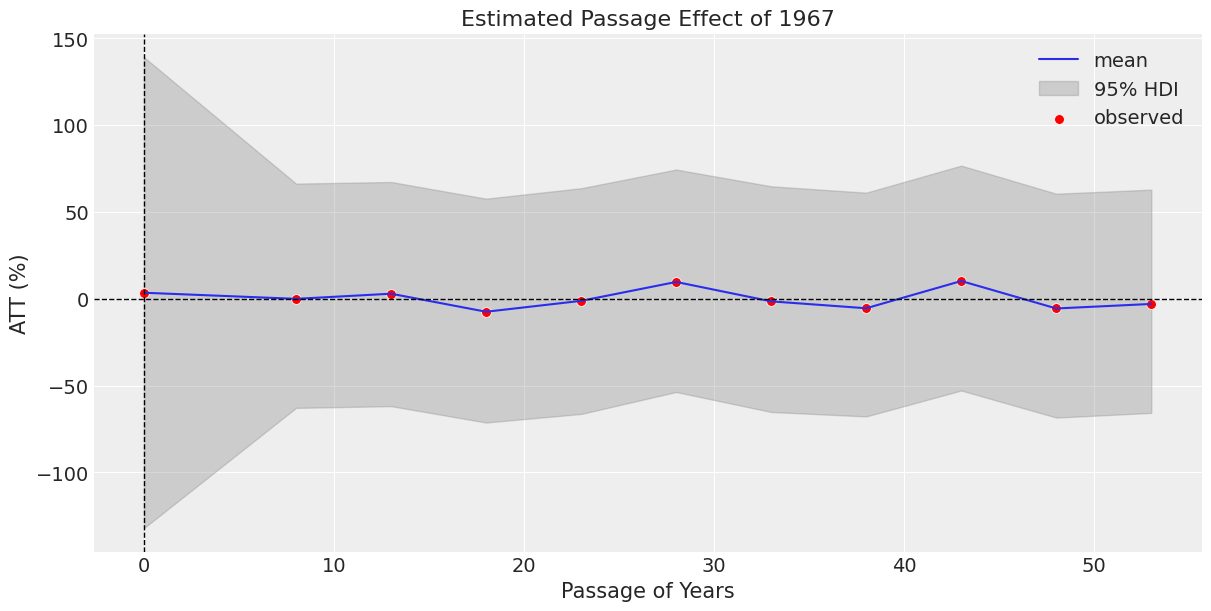

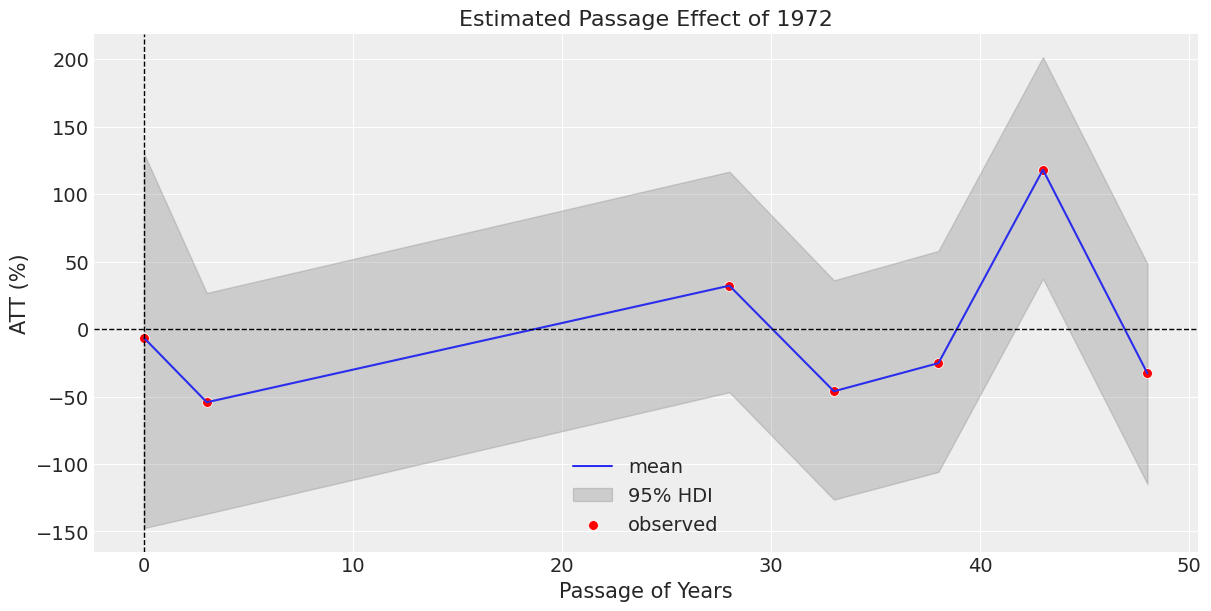

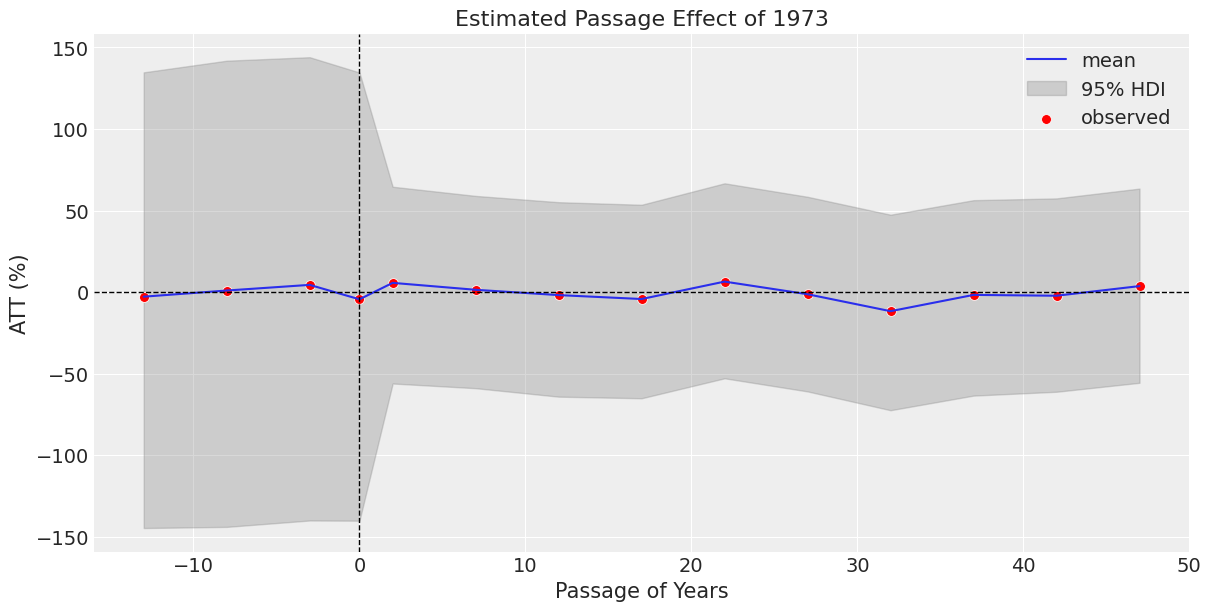

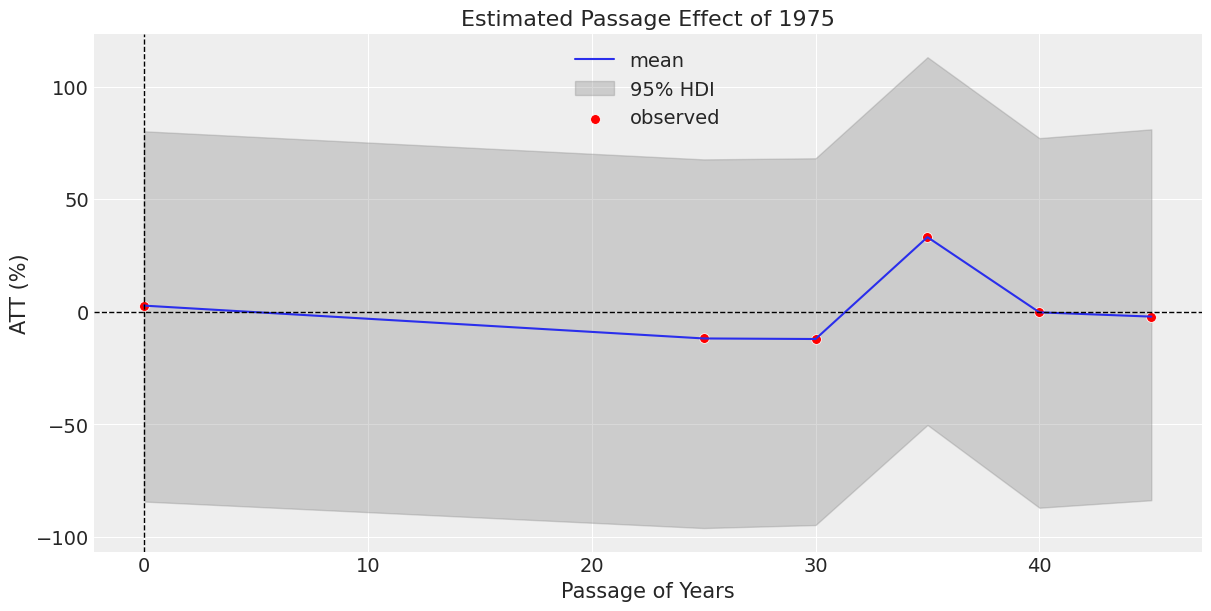

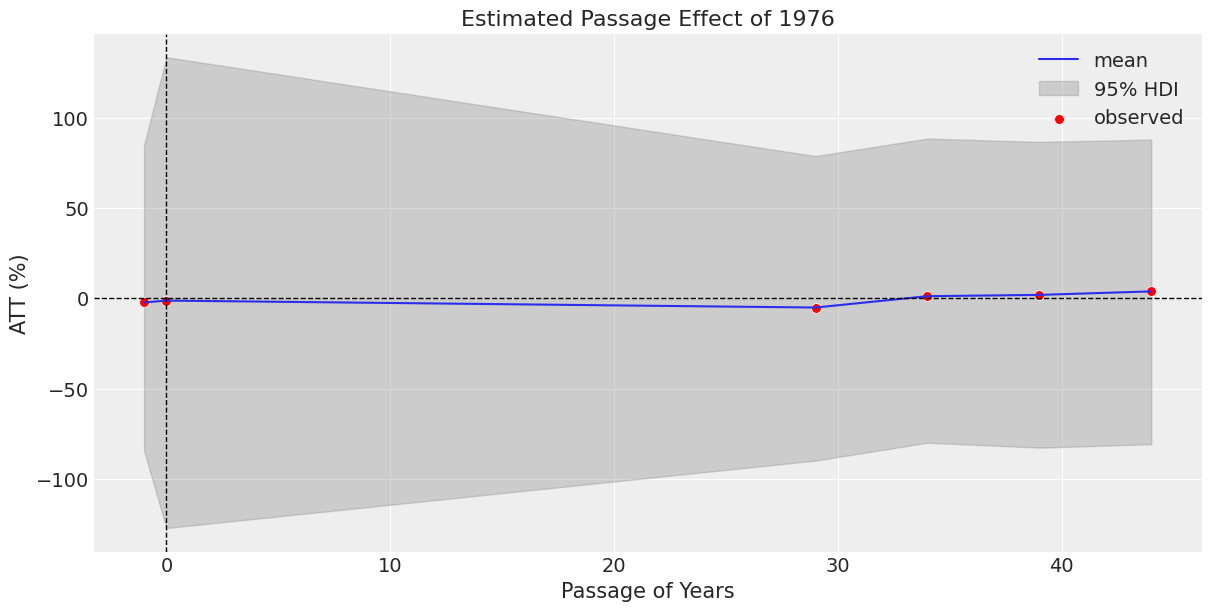

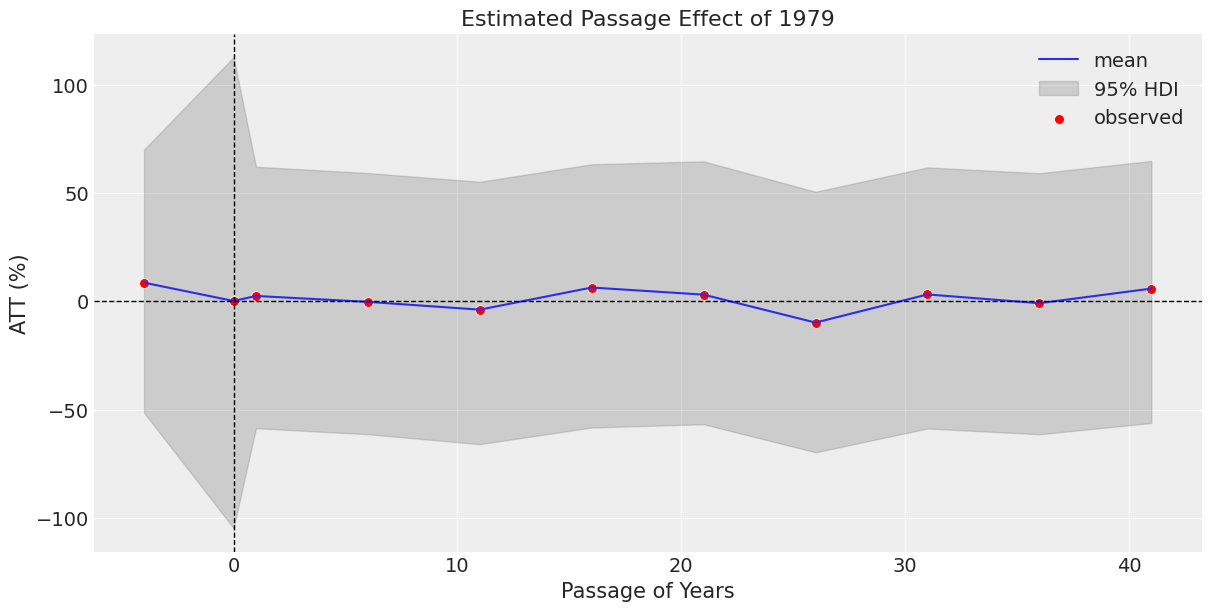

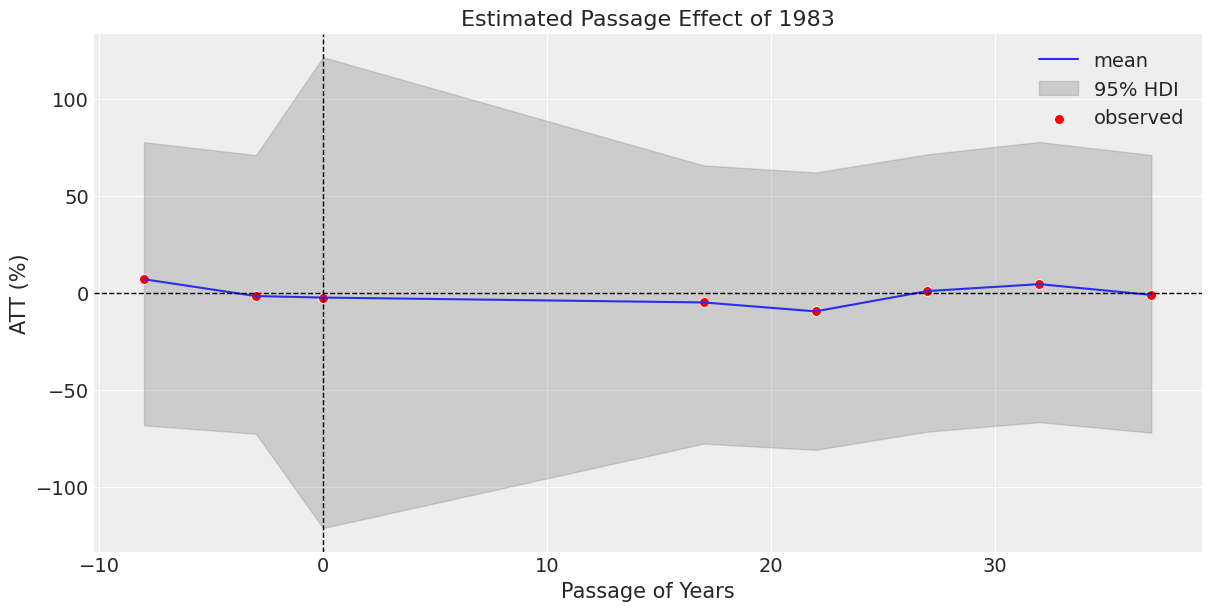

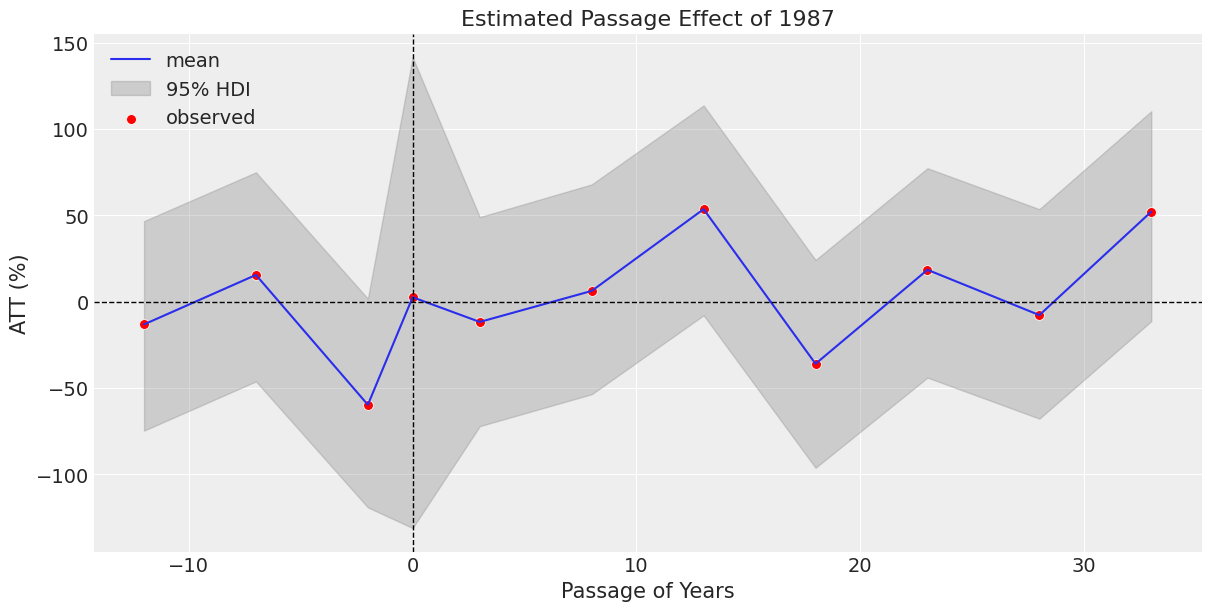

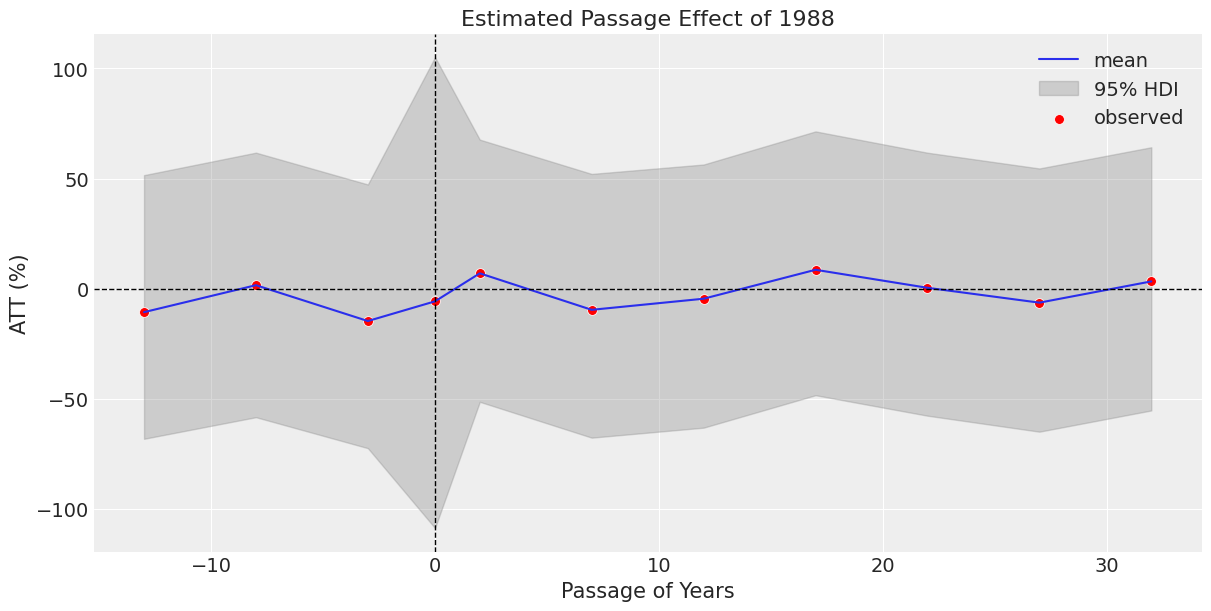

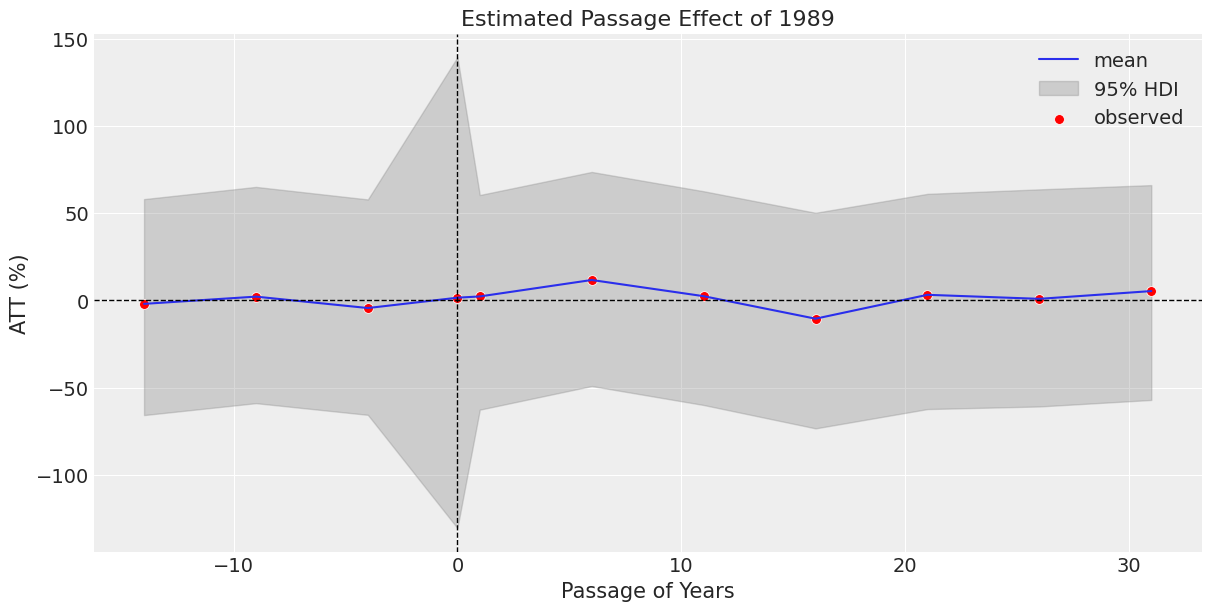

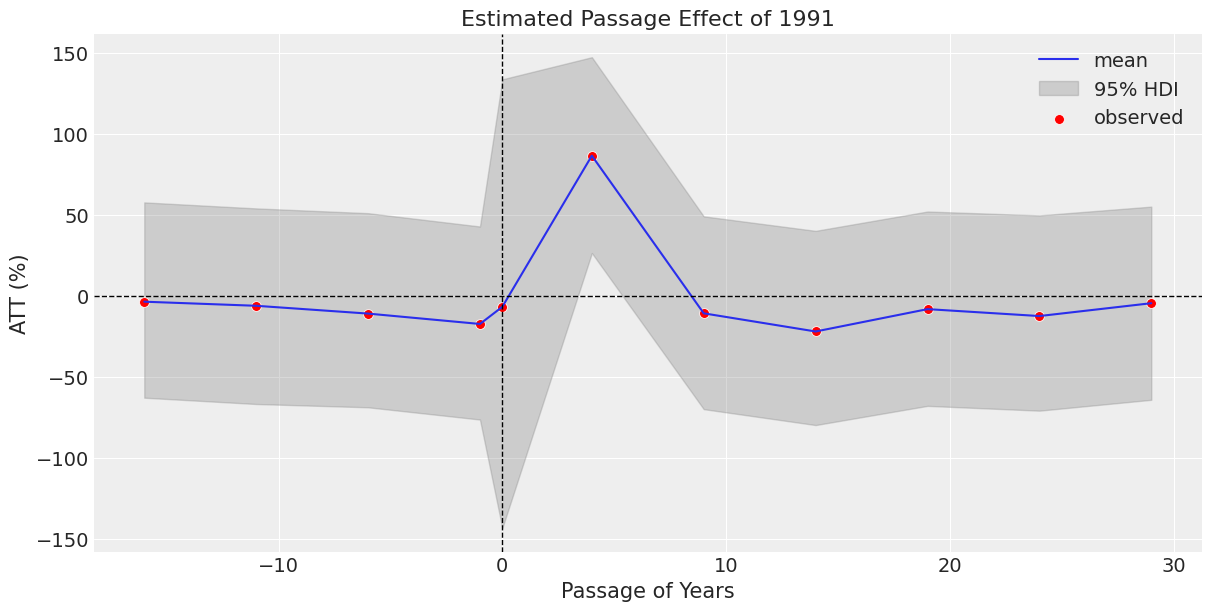

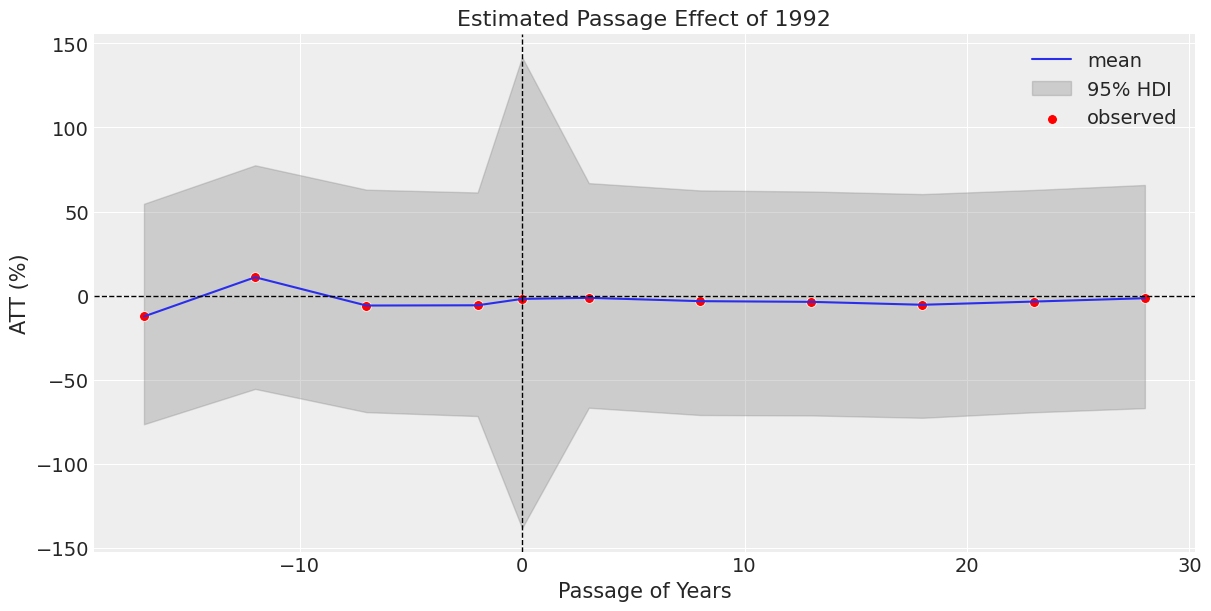

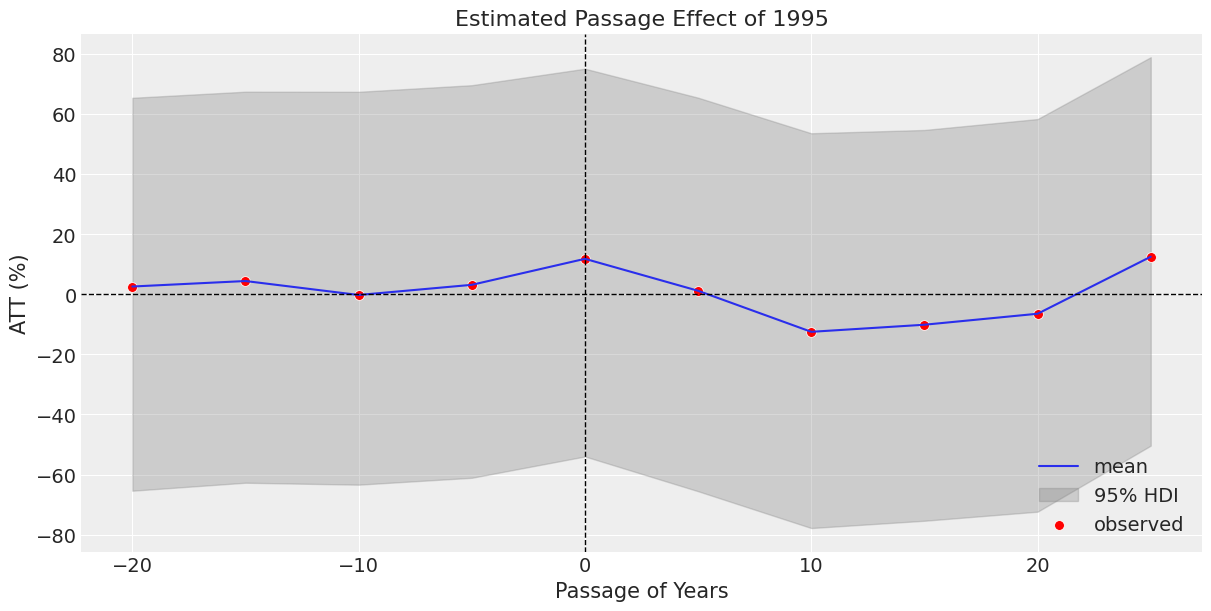

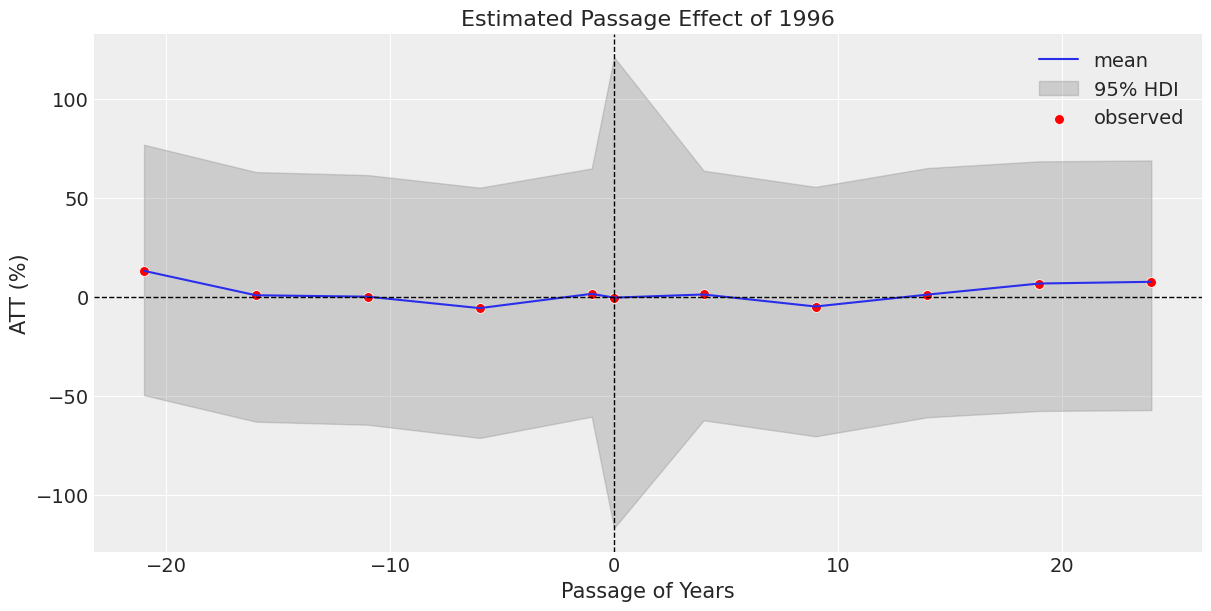

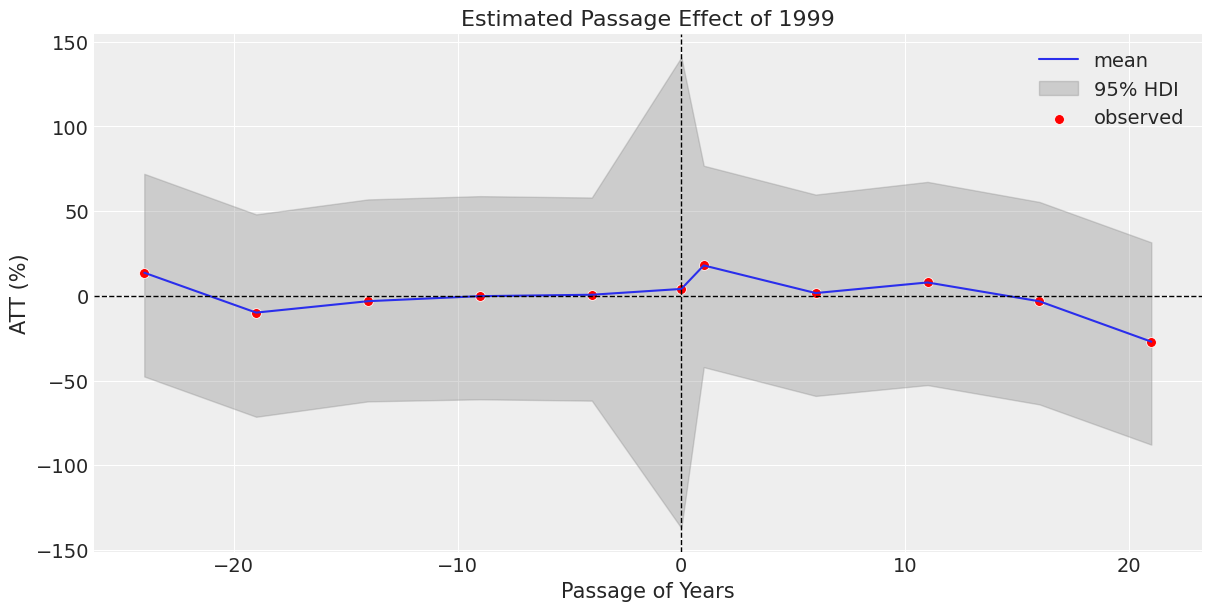

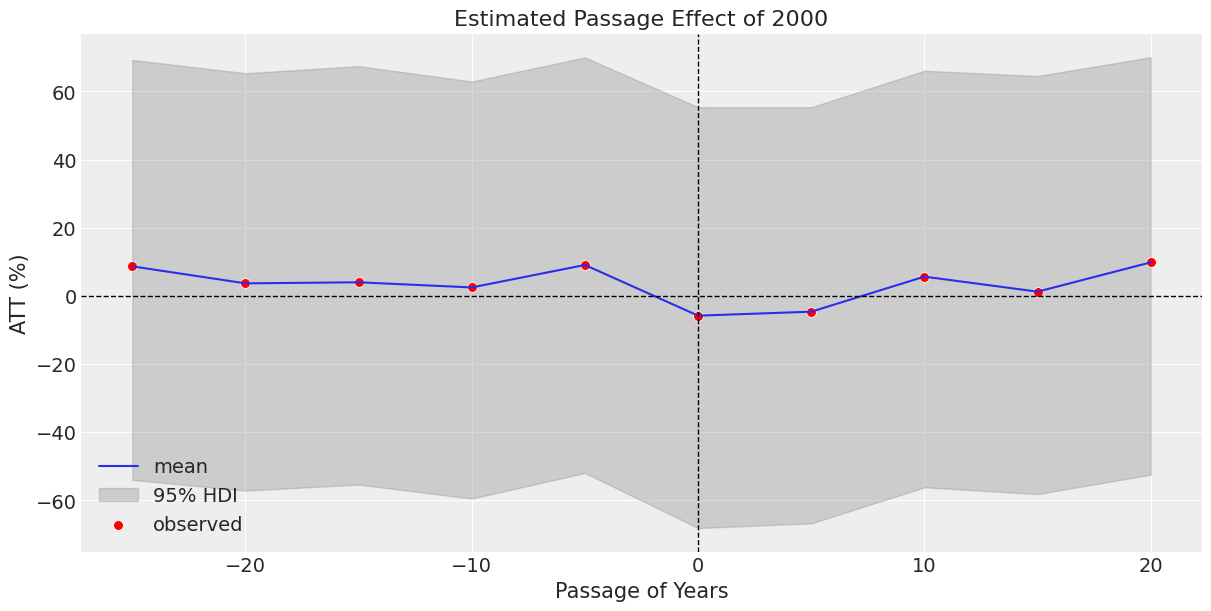

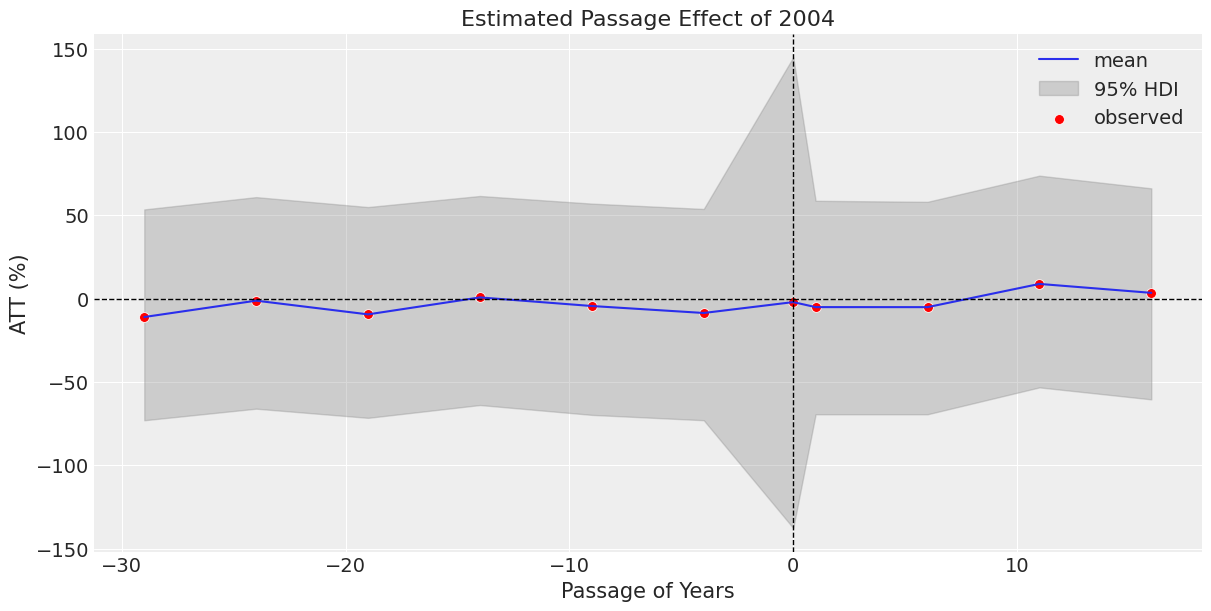

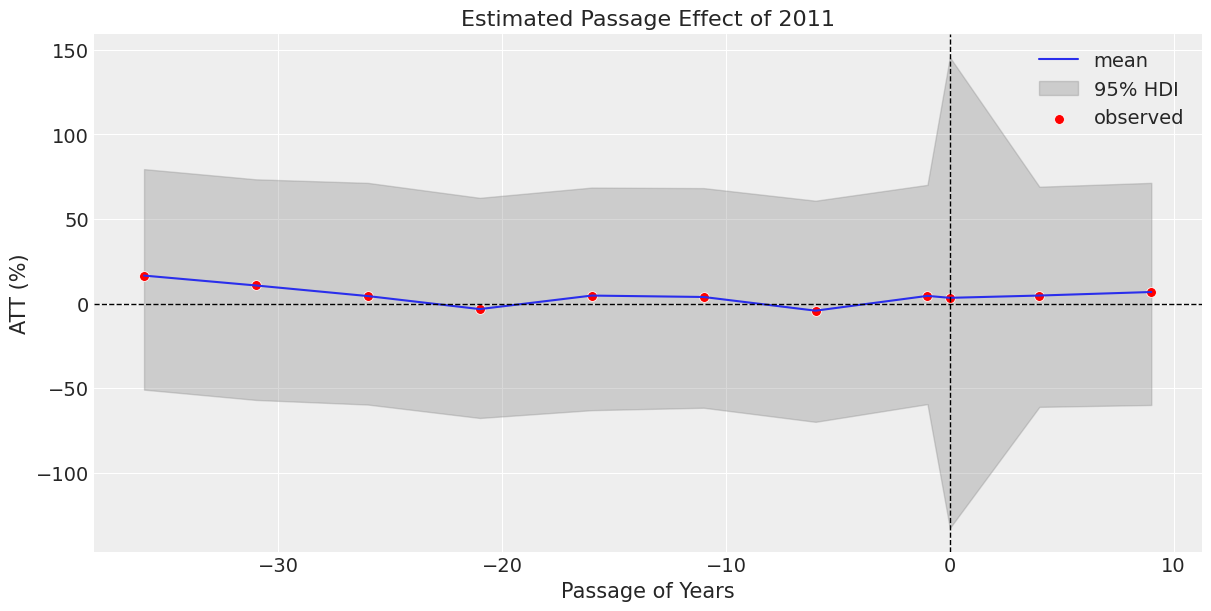

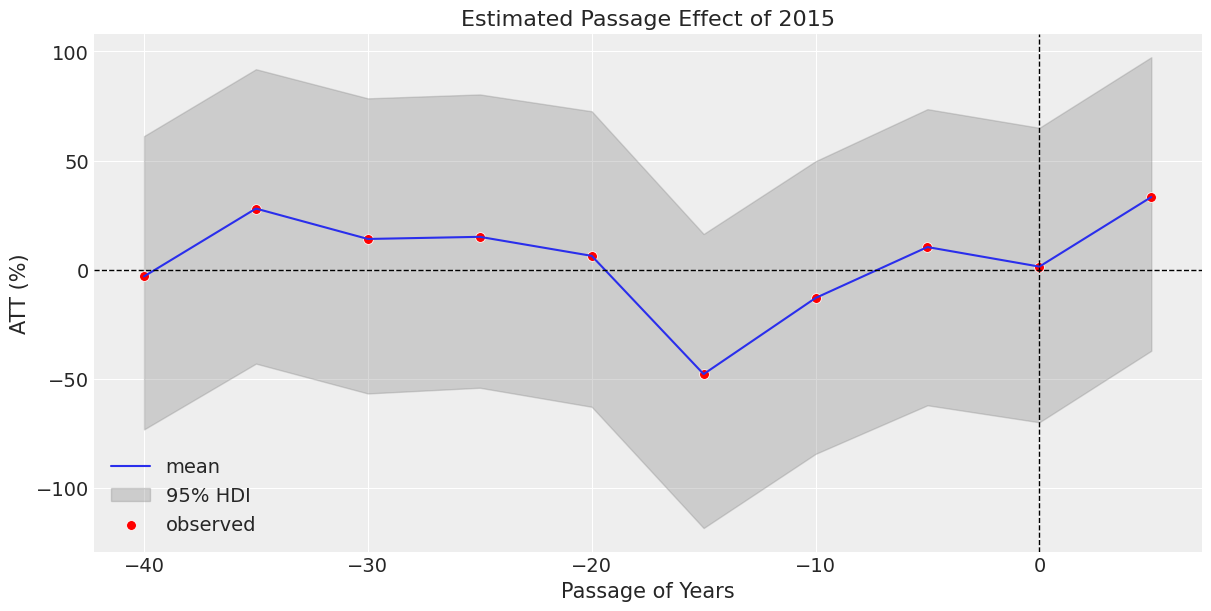

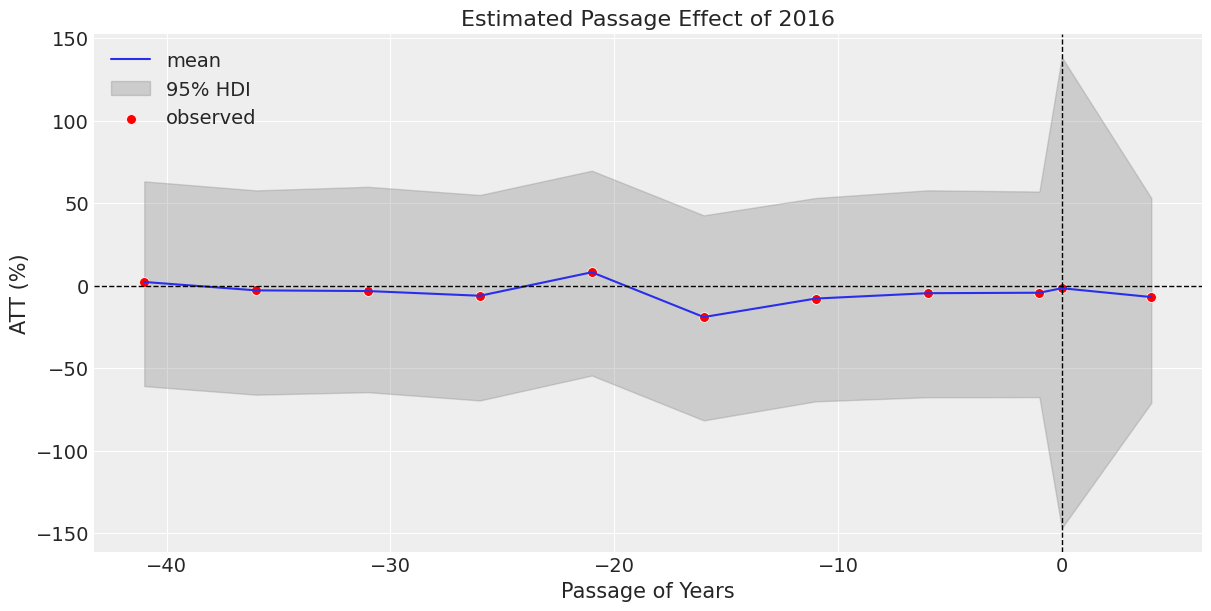

In [49]:
cohort_list = cohort_list[cohort_list != 0]
for cohort in cohort_list:
    get_passage_effects(cohort)

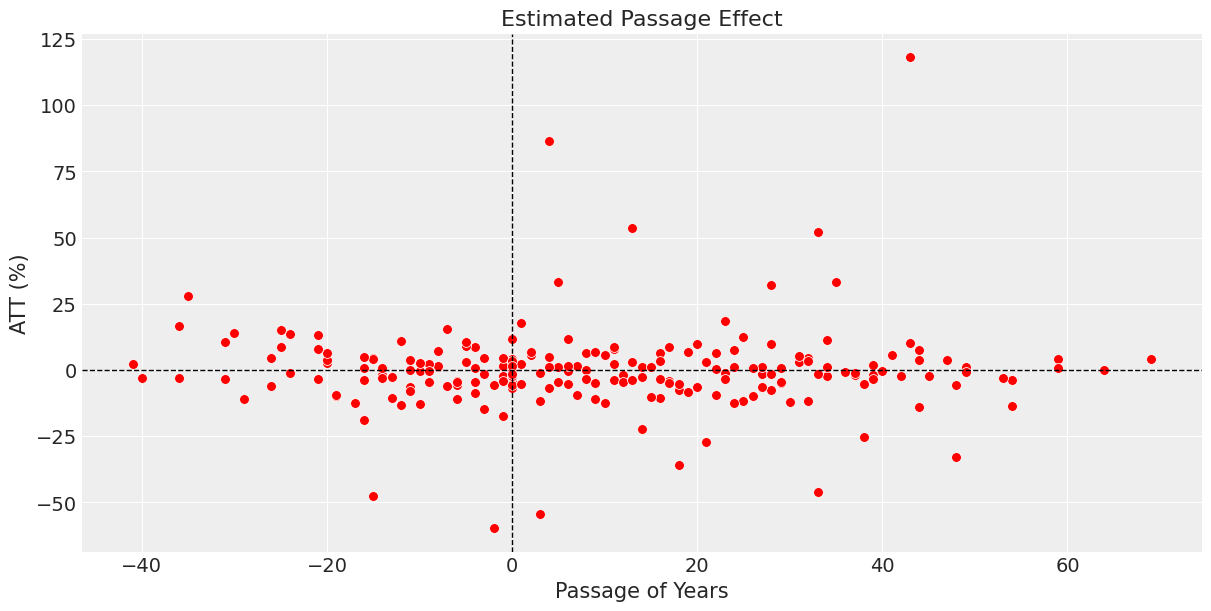

In [54]:
def get_passage_effects(cohort):
    summary = az.summary(idata_staggered, var_names=[f'mu_c{cohort}'], hdi_prob=.95)
    df_cohort_effects_ = summary.reset_index()
    # 数値部分を取り出す関数
    def extract_number(index_str):
        match = re.search(r'\[(-?\d+)\]', index_str)
        return int(match.group(1)) if match else None

    # 数値部分を新しい列として追加
    df_cohort_effects_['passage_years'] = df_cohort_effects_['index'].apply(extract_number)
    df_cohort_effects_.sort_values('passage_years', inplace=True)

    return df_cohort_effects_

plt.figure(figsize=(12, 6))
for cohort in cohort_list:
    df_cohort_effects_ = get_passage_effects(cohort)
    sns.scatterplot(x='passage_years', y='mean', data=df_cohort_effects_, color='red', s=50)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.title(f'Estimated Passage Effect')
plt.xlabel('Passage of Years')
plt.ylabel('ATT (%)')
plt.show()

In [ ]:
with staggered:
    pm.compute_log_likelihood(idata_staggered)

Output()

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:1043: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 20000 posterior samples and 627 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -2648.47    30.32
p_loo      406.72        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      473   75.4%
   (0.70, 1]   (bad)        49    7.8%
   (1, Inf)   (very bad)  105   16.7%



/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:1043: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/plots/khatplot.py:184: FutureWarning: support for DataArrays will be deprecated, please use ELPDData.The reason for this, is that we need to know the numbers of drawssampled from the posteri

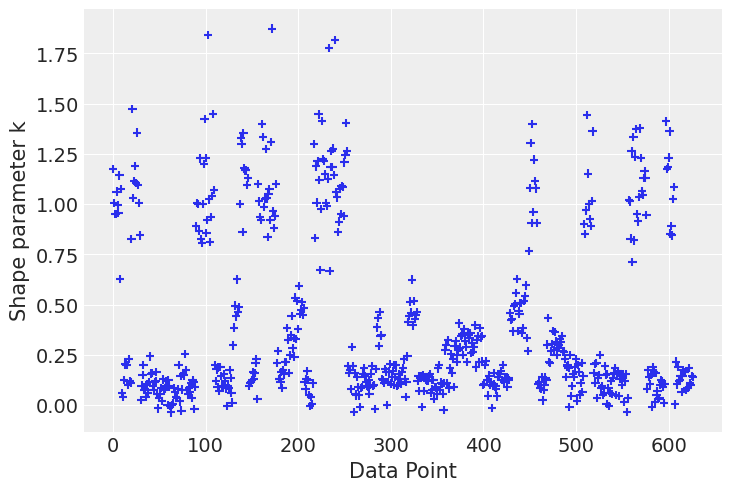

Computed from 20000 posterior samples and 627 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -2648.47    30.32
p_loo      406.72        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      473   75.4%
   (0.70, 1]   (bad)        49    7.8%
   (1, Inf)   (very bad)  105   16.7%



In [57]:
loo = az.loo(idata_staggered, pointwise=True)
pareto_k = loo.pareto_k
az.plot_khat(pareto_k)
plt.show()
print(loo)

In [60]:
# 影響力のある観測値を特定
influential_points = pareto_k[pareto_k > 0.7]

# 影響力のある観測値のインデックスを表示
print(influential_points.obs_id)

<xarray.DataArray 'obs_id' (obs_id: 154)> Size: 1kB
array([  0,   1,   2,   3,   4,   5,   6,   7,   9,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  90,  91,  92,  93,  94,  95,  96,  97,  98,
        99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 157, 158, 159, 160, 161, 162, 163,
       164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 217,
       218, 219, 220, 221, 222, 223, 225, 226, 227, 228, 229, 230, 231, 232,
       233, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247,
       248, 249, 250, 251, 252, 253, 449, 450, 451, 452, 453, 454, 455, 456,
       457, 458, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 557, 558,
       559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572,
       573, 574, 575, 576, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606])
Coordinates:
  * obs_id   (obs_id) int64 1kB 0 1 2 3 4 5 6 7 ... 600 601 602 603 604 605 606
